In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [11]:
# target_conditions = ["10X"]
removed_viallni = ['Villani']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
source_adata = adata_villani_removed[adata_villani_removed.obs.study.isin(['Freytag'])].copy()
source_conditions = source_adata.obs['batch'].unique().tolist()
print(adata_villani_removed.obs['batch'])
source_adata, source_conditions

index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC']


(AnnData object with n_obs × n_vars = 3347 × 12303
     obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
     layers: 'counts',
 ['Freytag'])

In [12]:
removed_batches = ['Freytag']
adata_tasks = adata_villani_removed[~adata_villani_removed.obs.study.isin(removed_batches)].copy()
adata_tasks_obs = adata_tasks.obs['batch']
tasks_list = list(set(adata_tasks_obs))
tasks_list

['Sun_sample3_TB',
 'Oetjen_U',
 'Sun_sample2_KC',
 'Oetjen_A',
 'Oetjen_P',
 '10X',
 'Sun_sample1_CS',
 'Sun_sample4_TC']

In [13]:
source_adata.raw = source_adata

In [14]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [15]:
sc.pp.normalize_total(source_adata)

In [16]:
sc.pp.log1p(source_adata)

In [17]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [19]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [20]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [21]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='LR+EWC',
)

LR+EWC is happening!
 |█████---------------| 25.0%  - val_loss: 445.9166361491 - val_recon_loss: 442.0112101237 - val_kl_loss: 6.2990570068 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |█████---------------| 26.4%  - val_loss: 440.9086608887 - val_recon_loss: 436.8016459147 - val_kl_loss: 6.2702450752 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Saving best state of network...
Best State was in Epoch 110


In [22]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

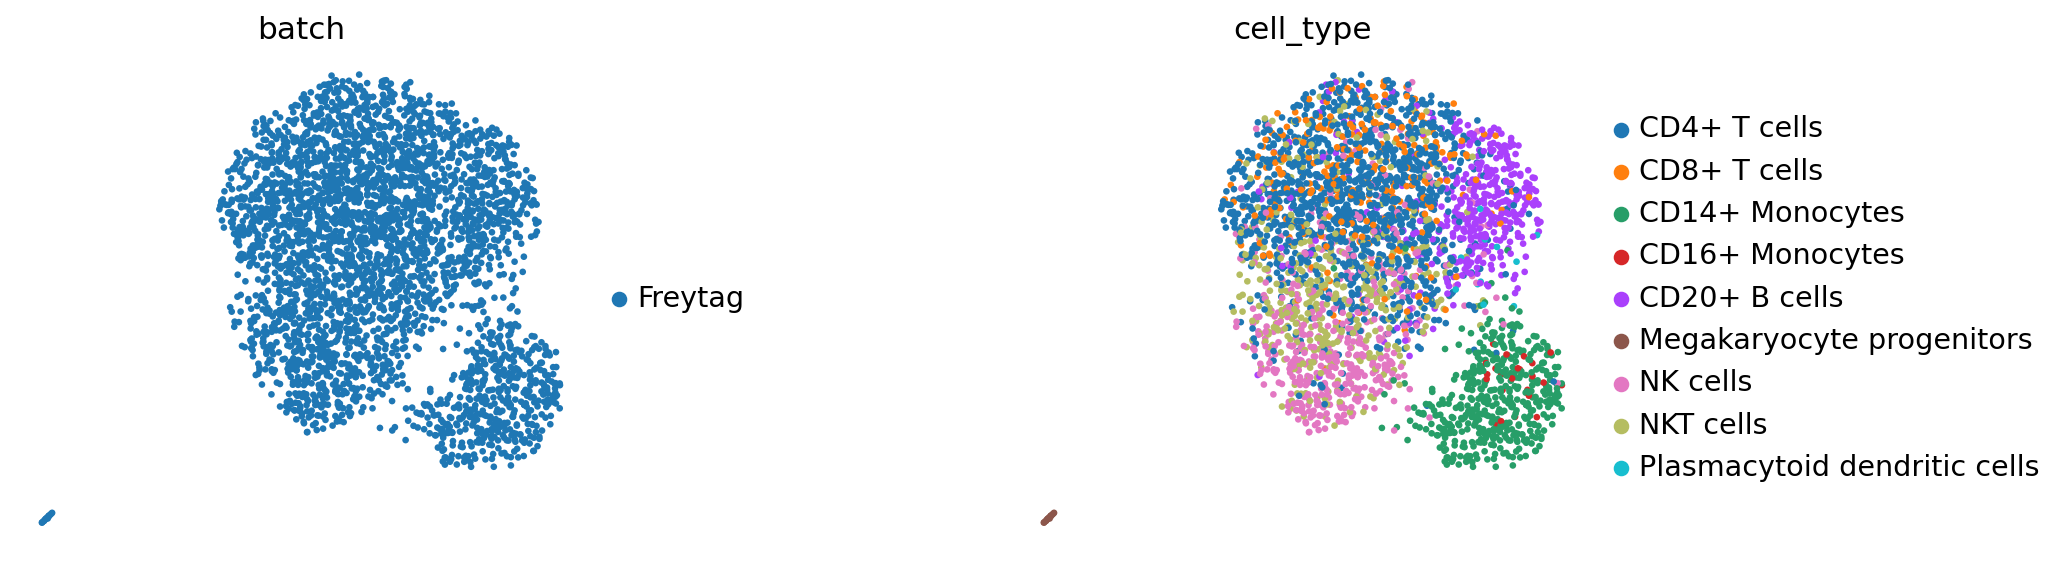

In [23]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [24]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [27]:
list_task_i = []
for ID, task in enumerate(tasks_list, start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID, task)
    task_i = adata_tasks[adata_tasks.obs['batch'].isin([task])]
    task_i = task_i[:, source_adata.var_names]
    new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'LR+EWC',
                                                 model=ref_path)
    new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'LR+EWC'
    )
    
    ref_path = 'reference_model_PBMC/'
    new_trvae.save(ref_path, overwrite=True)
    list_task_i.append(task_i)

1 Sun_sample3_TB

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

LR+EWC is happening!
 |██████--------------| 30.8%  - val_loss: 434.3759918213 - val_recon_loss: 426.3142852783 - val_kl_loss: 10.5381889343 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███████-------------| 37.2%  - val_loss: 434.5665588379 - val_recon_loss: 424.9423828125 - val_kl_loss: 10.4045133591 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███████-------------| 38.6%  - val_loss: 432.8720550537 - val_recon_loss: 422.8994903564 - val_kl_loss: 10.3880772591 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Savin

In [28]:
adata_full = source_adata.concatenate(list_task_i, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'trvae_size_factors', 'trvae_labeled', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [29]:
full_latent = sc.AnnData(new_trvae.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

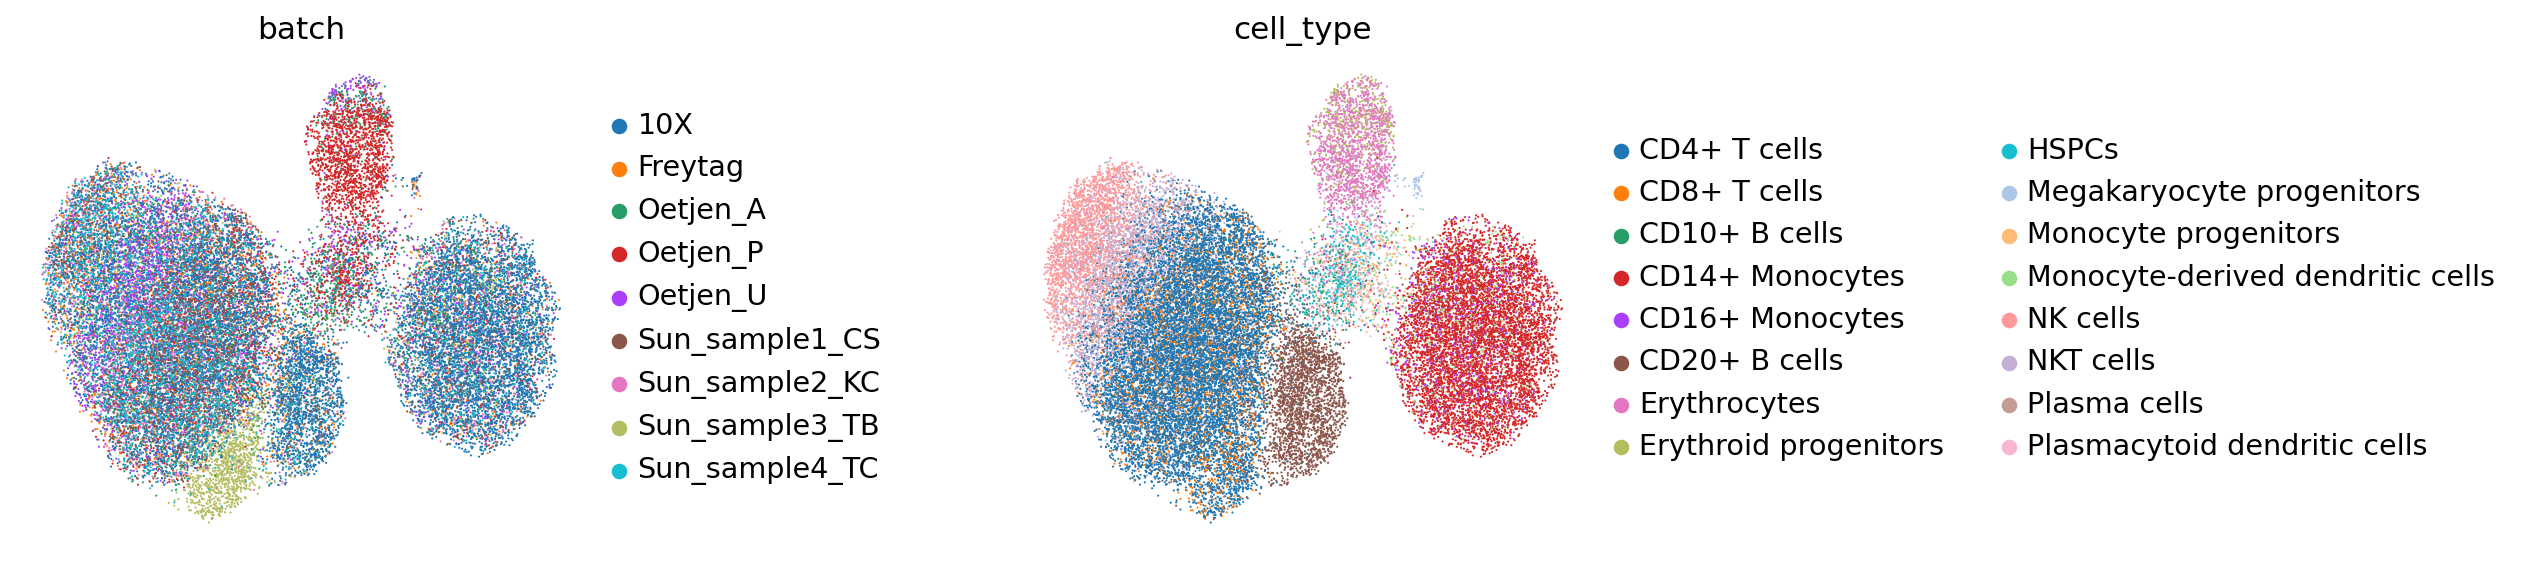

In [30]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [32]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 05:02:22


In [33]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_LR_1_EWC_1=scib.metrics.graph_connectivity(full_latent, 'batch')


Batch_corr_graph_conn_LR_1_EWC_1

0.4808110983989145

In [34]:
sc.tl.umap(full_latent)
Batch_corr_ASW_LR_1_EWC_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_LR_1_EWC_1

mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.789646
CD14+ Monocytes                           0.925031
CD16+ Monocytes                           0.912801
CD20+ B cells                             0.843698
CD4+ T cells                              0.827977
CD8+ T cells                              0.800119
Erythrocytes                              0.698078
Erythroid progenitors                     0.819718
HSPCs                                     0.775550
Megakaryocyte progenitors                 0.805235
Monocyte progenitors                      0.789481
Monocyte-derived dendritic cells          0.872868
NK cells                                  0.840653
NKT cells                                 0.881494
Plasma cells                              0.758959
Plasmacytoid dendritic cells              0.779440


0.820046794331812

In [35]:
Bio_cons_ASW_LR_1_EWC_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_LR_1_EWC_1

0.48397761210799217

In [36]:
isolated_labels_LR_1_EWC_1=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_LR_1_EWC_1

isolated labels: no more than 3 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


CD10+ B cells: 0.1007357102433503


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythrocytes: 0.7904570278815752


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythroid progenitors: 0.3711340206185567


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Monocyte progenitors: 0.2748863062152602


0.3843032662396856

In [37]:
pcr_LR_1_EWC_1=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_LR_1_EWC_1

0.6530582954689051